# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import palantir
import warnings
from tqdm.auto import tqdm

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# lasso regression imports
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from sklearn.linear_model import RidgeCV, LassoCV

from sklearn.preprocessing import StandardScaler

from scipy import stats


# Plot params

In [5]:
sc.set_figure_params(scanpy=False, frameon=False, format='png', transparent=True)

In [6]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [7]:
plot_prefix = 'plots/Fig3_'

# Functions

## General utility

In [8]:
import pickle

def pickled(file_path, obj):
    
    with open(file_path, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
def read_pickle(file_path):
    with open(file_path, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [10]:
def subset_ad(ad, cts):
    ad_sub = ad[ad.obs['celltype'].isin(cts), :].copy()
    ad_sub.uns['celltype_colors'] = list(ad_sub.uns['celltype_colors'])
    cell_order = ad_sub.obs.sort_values('palantir_pseudotime').index
    expr_sub = ad_sub.to_df()
    
    return ad_sub, expr_sub, cell_order

In [11]:
def get_gene_list(mc_ad, peak_counts, expr_thresh):
    if peak_counts is None:
        peak_counts = SEACells.genescores.get_peak_counts(mc_gp, max_pval=0.1, min_corr=0.1, return_peaks=False)
    valid_genes = peak_counts[peak_counts >=5].index
    
    mc_expr = mc_ad.to_df()
    highly_expressed = mc_expr.columns[(mc_expr.groupby(mc_ad.obs['celltype']).mean().loc[['Ery', 'HSC', 'MEP']] > expr_thresh).any()]
    
    
    final_gene_list = np.intersect1d(valid_genes, de_genes)
    final_gene_list = np.intersect1d(final_gene_list, highly_expressed)
    
    print(f'highly expressed: {len(highly_expressed)}')
    print(f'valid correlation: {len(valid_genes)}')

    print(f'total genes: {len(final_gene_list)}')
    
    return final_gene_list

## PWMs

In [12]:
def filter_gene(ad, gene_list):
    has_expr = [g in gene_list for g in ad.var_names]
    frac = sum(has_expr) / len(has_expr)
    print(f"{frac:.2%} ({sum(has_expr)}) TFs have expresssion")
    
    ad = ad[:, has_expr]
    
    return ad

In [13]:
def format_peaks(peaks):
    peak_names = (peaks['names'].values + ':' + peaks['start'].astype(str) + '-' + peaks['end'].values.astype(str)).values
    return peak_names

## gene-TF computation

In [14]:
def gene_tf_associations(gene_peak, peak_x_tf, 
                         min_corr=0.0, max_pval=0.1, min_peaks=0, 
                         ct_peaks=None, gene_set=None):
    
    tfs = peak_x_tf.var_names
    n_tfs=len(tfs)
    
    # initialize returns
    gene_tfs = {}
    n_gp_assoc = 0

    for gene, peak_df in tqdm(gene_peak.items(), 
                              desc="genes", 
                              total=len(gene_peak)):
        if gene_set is None:
            gene_set = gene_peak.keys()
            
        if gene not in gene_set or not isinstance(peak_df, pd.DataFrame):
                # skip genes with no peaks
                continue
        if ct_peaks is None:
            sig_peaks = (peak_df['pval'] < max_pval) & (peak_df['cor'] > min_corr)
            if all(~sig_peaks):
                # no significant peaks
                continue
            # grab list of sig peaks correlated with this gene
            peaks = peak_df.loc[sig_peaks, :].index
        else: 
            valid_peaks = [x for x in peak_df.index if x in ct_peaks]
            
            if len(valid_peaks) == 0:
                continue
            peaks = peak_df.loc[valid_peaks, :].index
        
        if len(peaks) >= min_peaks:
            # convert scores to bool, 0 = False (peak x tf)
            tf_association = peak_x_tf[peak_x_tf.obs_names.isin(peaks), :].X
            tf_association = tf_association.toarray().astype(bool)
            
            # Grab TFs that are associated with a peak at least once 
            tf_idxs = np.where(np.any(tf_association, axis=0))[0]
            
            gene_tfs[gene] = {}
            for tf in tf_idxs:
                tf_name = peak_x_tf.var_names[tf]
                tf_mask = tf_association[:, tf] # subset the PWM scores to the relevant tf
                
                gene_tfs[gene][tf_name] = peaks[tf_mask]

                # grab the peaks for each tf
                n_gp_assoc += 1
    
    # log number of genes that passed thresholds
    print(f"{len(gene_tfs):,} genes and {n_gp_assoc:,} gene-TF combinations with at least {min_peaks} peaks.")

    return gene_tfs

In [60]:
def compute_gene_tf_mat(peak_x_tf, gene_peak, gene_tfs, ct_specific=False):
    
    tfs = peak_x_tf.var_names

    # initiate three DFs
    gtf_fw = pd.DataFrame(0.0,index=gene_peak.index, columns=tfs)
    
    fimo_scores = peak_x_tf.to_df()
    
    for gene, tf_dict in tqdm(gene_tfs.items(),total=len(gene_tfs)):
        for tf, peaks in tf_dict.items():
            
            if ct_specific:
                #print(f'{gene}-{tf}: {len(peaks)}')    
                fimo = fimo_scores.loc[peaks, tf].sum()
            else:

                # Compute weighted FIMO score
                corrs = gene_peak[gene].loc[peaks, 'cor']
                fimo = (fimo_scores.loc[peaks, tf].values * corrs.values).sum()
            
            gtf_fw.loc[gene,tf] = fimo
    
    return gtf_fw

## gene selection

In [16]:
def get_ct_markers(adata, clusters, thresh):
    final_dict = {}
    print('threshold:', thresh)
    print()
    for cluster in tqdm(clusters, total=len(clusters)):
        cluster_dict={}
        
        ref = [x for x in clusters if x != cluster]
        get_de_genes(adata,cluster, cluster_dict, ref,)
        
        gene_list = []
        for gene in cluster_dict:
            if cluster_dict[gene] >= thresh:
                gene_list.append(gene)
        
        num_genes = len(gene_list)

        print(cluster)
        print('\tnum genes:', num_genes)
        
        gene_names = []
        for gene in gene_list:
            gene_names.append(gene)
            
        final_dict[cluster] = gene_names
        
    return final_dict

In [17]:
def get_de_genes(adata, ct, ct_dict, references, fc_min=1.5, pval_cut=1e-2):
    sc.settings.verbosity = 0 
    for ref in references:
        de_data = sc.tl.rank_genes_groups(adata, groupby='celltype', groups=[ct], reference=ref, use_raw=False, copy=True)

        de_genes = sc.get.rank_genes_groups_df(de_data, ct, pval_cutoff=pval_cut, log2fc_min=fc_min)

        valid_de_df = de_genes.sort_values(by='logfoldchanges', ascending=False)
        
        for gene in valid_de_df['names']:                
            if gene not in ct_dict:
                ct_dict[gene] = 1
            else: 
                ct_dict[gene] += 1
    sc.settings.verbosity = 1
    

## gene trend computation

In [18]:
from pygam import LinearGAM, s
def gam_fit_predict(x, y, weights=None, pred_x=None, n_splines=10, spline_order=4):
    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

    # Construct dataframe
    use_inds = np.where(weights > 0)[0]

    # GAM fit
    gam = LinearGAM(s(0, n_splines=n_splines, 
                      spline_order=spline_order)).fit(x[use_inds], y[use_inds], 
                                                      weights=weights[use_inds])
    # Predict
    if pred_x is None:
        pred_x = x
    y_pred = gam.predict(pred_x)

    # Standard deviations
    p = gam.predict(x[use_inds])
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) **
                2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )
    return y_pred, stds

## Lasso regression

In [19]:
def fit_model(gtf, zs, tf_filt, gene_set, cells, max_iter=10000 ):
    X = gtf.loc[gene_set, tf_filt]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), index=gene_set, columns=tf_filt)
    
    coefs = {}
    base_rmses = {}
    r_sqs = {}
    sp_corrs = {}
    x_tests = {}
    y_stats = {}
    intercepts = {}
    
    for cell in tqdm(cells, total=len(cells)):
        y = zs.loc[gene_set, cell]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        
        lasso_cv_model = LassoCV(cv = 5, max_iter=max_iter, n_jobs=16).fit(X_train,y_train)
        opt_alpha = lasso_cv_model.alpha_
        lasso_tuned = Lasso().set_params(alpha=opt_alpha).fit(X_train, y_train)
        y_pred = lasso_tuned.predict(X_test)

        # save stats
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r_sq = r2_score(y_test, y_pred)
        sp_corr = stats.spearmanr(y_test, y_pred)

        base_rmses[cell] = rmse
        r_sqs[cell] = r_sq
        sp_corrs[cell] = sp_corr
        x_tests[cell] = X_test
        y_stats[cell] = y_test, y_pred
        intercepts[cell] = lasso_tuned.intercept_
        coefs[cell] = pd.Series(lasso_tuned.coef_, index=X.columns).sort_values()
    
    # save all outputs into dict
    res = {}
    
    res['coefs'] = coefs
    res['rmses'] = base_rmses
    res['rsqs'] = r_sqs
    res['sp_corr'] = sp_corrs
    res['x_tests'] = x_tests
    res['intercept'] = intercepts
    res['y_stats'] = y_stats
    
    return res

In [20]:
def filter_tfs(cts, tfs):
    tf_zs = pd.DataFrame(sc.pp.scale(mc_ad.to_df()[tfs].values, copy=True), index=mc_ad.to_df().index, columns=tfs)
    ct_zs = (tf_zs.groupby(mc_ad.obs['celltype']).mean() > 1 )!= 0
    tf_filt = tfs[ct_zs.loc[cts].sum() >0]
    return tf_filt

## TF-Activity

In [21]:
def non_zero_tfs(cells, ct_res, thresh=20):
    tf_count = {}

    for cell in tqdm(cells, total=len(cells)):
        coefs = ct_res['coefs'][cell]
        coefs = coefs[coefs != 0]
        for tf in coefs.index:
            if tf not in tf_count:
                tf_count[tf] = 1
            else:
                tf_count[tf] += 1
    valid_tfs = [tf for tf in tf_count.keys() if tf_count[tf] >= thresh]
    print(f'Number of Qualifying TFs: {len(valid_tfs)}')
    
    return valid_tfs

In [22]:
def find_error_change(ad_sub, res, valid_tfs, cells):
    
    cell_order = ad_sub.obs.loc[cells,:].sort_values('palantir_pseudotime').index
    dependencies = pd.DataFrame(0.0, index=valid_tfs, columns=cell_order) # set up container
    
    for cell in tqdm(cells, total=len(cells)):
        X_test = res['x_tests'][cell]
        y_test = res['y_stats'][cell][0]
        y_pred = res['y_stats'][cell][1]
        coefs = res['coefs'][cell].copy()
        intercept = res['intercept'][cell]       
        rmse = res['rmses'][cell]

        for tf in valid_tfs:            
            if coefs.loc[tf] >= 0:
                sign = 1
            else:
                sign = -1
            
            new_coefs = coefs.copy()
            new_coefs.loc[tf] = 0
            new_y_pred = (X_test[new_coefs.index] * new_coefs).sum(axis=1) + intercept

            new_rmse = np.sqrt(mean_squared_error(y_test, new_y_pred))
            diff = np.abs(new_rmse - rmse)
            
            # fill in container
            dependencies.loc[tf, cell] = diff * sign
    
    return dependencies

In [23]:
def top_tfs(tf_activities, n_tfs=5):
    sorted_tfs = np.abs(tf_activities).sum(axis=1).sort_values(ascending=False).index
    return sorted_tfs[0:n_tfs]

### Plotting

In [24]:
def plot_dependencies(ct_ad, ct_depend, fsize=(10,10),save=False, fname=None, row_cluster=True):
    ct_colors = dict(zip(ct_ad.obs['celltype'].cat.categories, ct_ad.uns['celltype_colors']))
    ct_col_colors = ct_ad.obs['celltype'].map(ct_colors)

    pal = sns.palettes.color_palette('plasma', len(ct_ad.obs_names))
    lut = dict(zip(np.sort(mc_sub.obs['palantir_pseudotime'].unique()), pal))
    pt_col_colors = ct_ad.obs['palantir_pseudotime'].map(lut)
    
    col_colors = pd.DataFrame({'celltype':ct_col_colors,
                               'pseudotime':pt_col_colors})

    g = sns.clustermap(ct_depend, col_cluster=False, row_cluster=row_cluster,cmap='RdBu_r', vmin=-0.01, vmax=0.01,
                       col_colors=col_colors,  xticklabels=False, figsize=fsize, cbar_pos=(0.1, 0.8, 0.01, 0.3))
    
    g.ax_row_dendrogram.set_visible(False)
    if save:
        g.savefig(f'./figures/{fname}.png', dpi=200, bbox_inches='tight')

# Load data

In [25]:
data_dir = '/fh/fast/setty_m/user/msetty/projects/metacells/data/CD34/Multiome/'

In [26]:
mc_ad = sc.read('/home/cdien/cdien_fast/seacells/anndatas/reaggr_rna_mc.h5ad')

In [27]:
ct_colors = dict(zip(mc_ad.obs['celltype'].cat.categories, mc_ad.uns['celltype_colors']))

In [28]:
# single cell
rna_ad = sc.read('/home/cdien/projects/seacells/data/rna_ad.h5ad')

In [29]:
# subset to Erythroid trajectory
ery_cts = ['HSC', 'Ery', 'MEP']
mc_sub, mc_expr, mc_co = subset_ad(mc_ad, ery_cts)

## gene - peak correlation

In [30]:
# metacell:
mc_gp = read_pickle('/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/dorc-scores/cd34_meta_dorc_correlations.p')

In [31]:
# cell type specific
ap_gp = read_pickle('./cd34_bm_gp.pickle')

## PWMs

In [32]:
peak_tf = sc.read('/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/pwm_ad.h5ad')
peak_tf

AnnData object with n_obs × n_vars = 246113 × 729

In [33]:
peak_tf = filter_gene(peak_tf, mc_ad.var_names)

41.29% (301) TFs have expresssion


### cell type specific

In [36]:
ct_peak_tf = sc.read('/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/arch_vanilla_peaks/peak_x_tf.h5ad')
ct_peak_tf

AnnData object with n_obs × n_vars = 269929 × 1068

In [37]:
ct_peak_tf = filter_gene(ct_peak_tf, mc_ad.var_names)

53.84% (575) TFs have expresssion


## cell type specific peaks

In [38]:
ery_peaks = pd.read_csv('./ct_specific_peaks/ery_100_strict_peaks.csv')
hsc_peaks = pd.read_csv('./ct_specific_peaks/hsc_100_strict_peaks.csv')
mep_peaks = pd.read_csv('./ct_specific_peaks/mep_100_strict_peaks.csv')

In [39]:
ct_peaks = {}
ct_peaks['Ery'] = format_peaks(ery_peaks)
ct_peaks['HSC'] = format_peaks(hsc_peaks)
ct_peaks['MEP'] = format_peaks(mep_peaks)

# Gene selection

In [40]:
cts = rna_ad.obs['celltype'].unique()

In [41]:
ct_dict = get_ct_markers(rna_ad,cts, 4 )

threshold: 4



  0%|          | 0/9 [00:00<?, ?it/s]

HMP
	num genes: 507
DCPre
	num genes: 592
HSC
	num genes: 639
Ery
	num genes: 1369
MEP
	num genes: 413
cDC
	num genes: 805
CLP
	num genes: 418
Mono
	num genes: 331
pDC
	num genes: 866


In [42]:
de_genes = list(set([gene for ct in ery_cts for gene in ct_dict[ct]]))

In [44]:
import SEACells
peak_counts = SEACells.genescores.get_gene_peak_assocations(mc_gp, pval_cutoff=0.1, cor_cutoff=0.1)

  0%|          | 0/12464 [00:00<?, ?it/s]

In [45]:
gene_set = get_gene_list(mc_ad, peak_counts, 30)

highly expressed: 7520
valid correlation: 3543
total genes: 589


# Gene trend computation and z-score

In [46]:
pseudotime = mc_sub.obs.sort_values('palantir_pseudotime')['palantir_pseudotime']

In [47]:
pred_expr = pd.DataFrame(0.0, index=gene_set, columns=pseudotime.index.copy())
for gene in gene_set:
    y_pred, stds = gam_fit_predict(pseudotime.values, mc_expr.loc[pseudotime.index, gene], 
                                   n_splines=20, spline_order=3)
    pred_expr.loc[gene] = y_pred

In [48]:
genes_oi = [x for x in ['CD34', 'GATA1','GATA2', 'HBB',  'KLF1'] if x in gene_set]

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


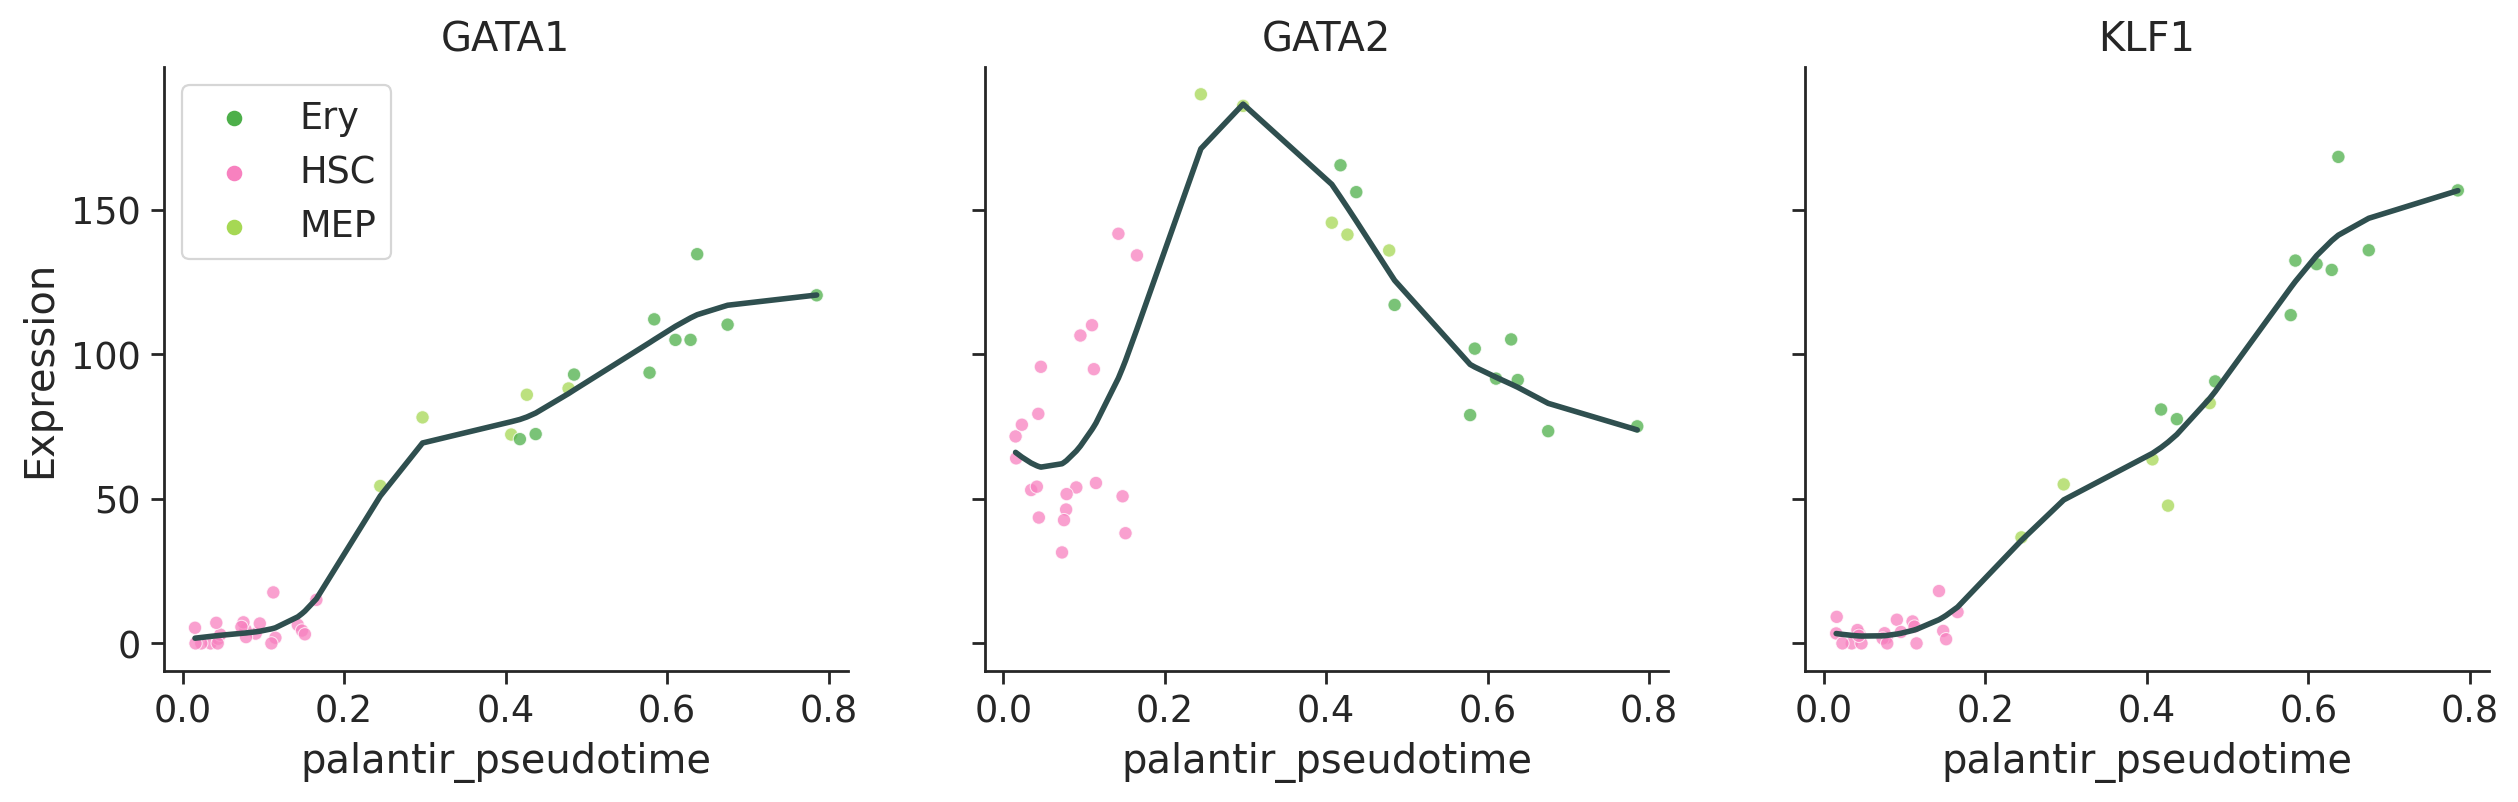

In [49]:
# 20, 3
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True, sharey=True)
for i in range(len(genes_oi)):
    sns.scatterplot(x=pseudotime, y=mc_expr[genes_oi[i]],alpha=0.75,hue=mc_sub.obs['celltype'], palette=mc_sub.uns['celltype_colors'], ax=axes[i])
    sns.lineplot(x=pseudotime, y=pred_expr.loc[genes_oi[i]], color='darkslategrey', ax=axes[i], linewidth=2)
    axes[i].set_title(genes_oi[i])
    axes[i].set_ylabel('Expression', fontname='Comic Sans MS')
    sns.despine()
for ax in axes[1:]:
    ax.legend().remove()

In [50]:
trend_ad = sc.AnnData(pred_expr.T)
trend_ad.obs = mc_sub[mc_co].obs.copy()
trend_ad.uns = mc_sub[mc_co].uns.copy()

In [51]:
mc_sub

AnnData object with n_obs × n_vars = 36 × 12464
    obs: 'celltype', 'palantir_pseudotime', 'n_counts'
    uns: 'celltype_colors'
    obsm: 'X_umap'

/home/cdien/.conda/envs/seacells2/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


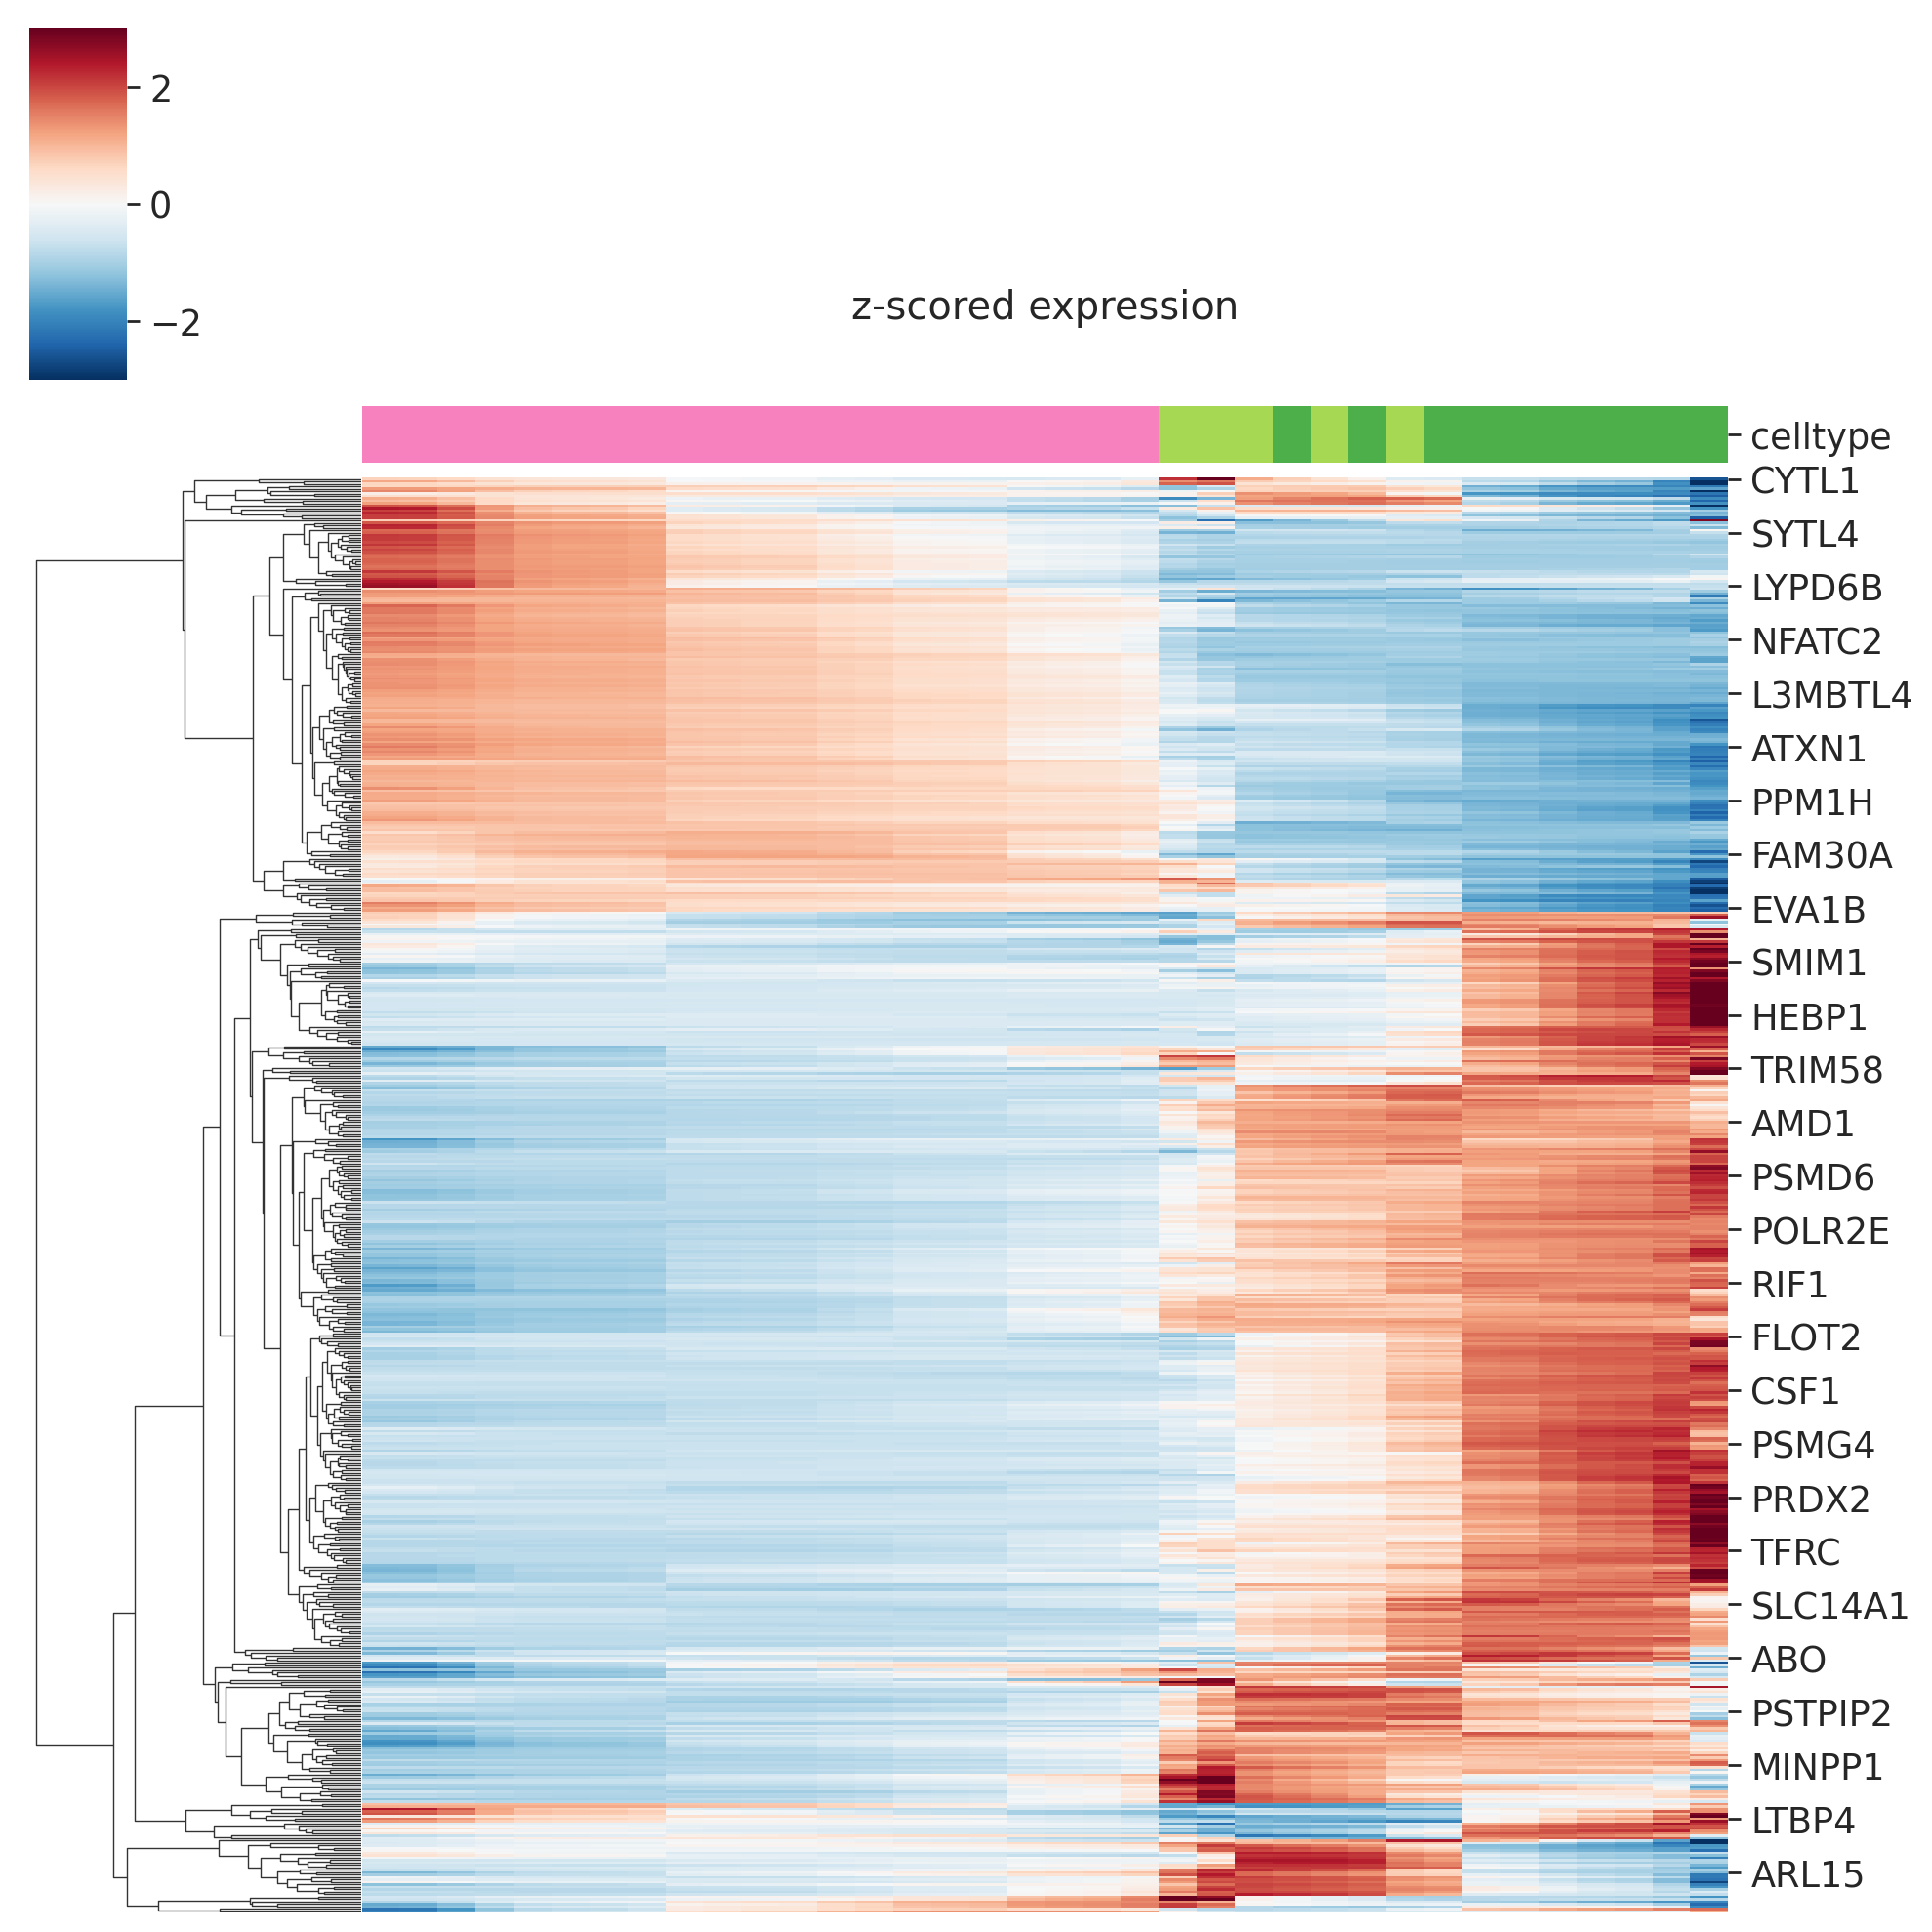

In [53]:
ery_zs = sc.pp.scale(trend_ad, copy=True).to_df()
col_colors = trend_ad.obs['celltype'].map(ct_colors)
cell_order = trend_ad.obs['palantir_pseudotime'].sort_values().index

g = sns.clustermap(ery_zs.loc[cell_order].T, cmap='RdBu_r', col_cluster=False, col_colors=col_colors, vmin=-3, vmax=3, xticklabels=False)
g.ax_heatmap.set_title('z-scored expression', y=1.1) 

gene_order = ery_zs.columns[g.dendrogram_row.reordered_ind]
zs = ery_zs.loc[cell_order, gene_order].T
plt.show()


# Feature matrix

In [54]:
genes = peak_counts[peak_counts >=5].index

In [55]:
mc_gene_tf = gene_tf_associations(mc_gp, peak_tf, min_corr=0.1,min_peaks=5)

genes:   0%|          | 0/12464 [00:00<?, ?it/s]

3,543 genes and 343,810 gene-TF combinations with at least 5 peaks.


In [56]:
mc_gtf = compute_gene_tf_mat(peak_tf, mc_gp, mc_gene_tf)

  0%|          | 0/3543 [00:00<?, ?it/s]

## cell type specific

In [58]:
ct_gene_tf = {}
for ct in tqdm(ery_cts, desc='celltypes', total=len(ery_cts)):
    ct_gene_tf[ct] = gene_tf_associations(ap_gp, ct_peak_tf, ct_peaks=ct_peaks[ct], gene_set=genes)

celltypes:   0%|          | 0/3 [00:00<?, ?it/s]

genes:   0%|          | 0/19611 [00:00<?, ?it/s]

3,322 genes and 681,129 gene-TF combinations with at least 0 peaks.


genes:   0%|          | 0/19611 [00:00<?, ?it/s]

3,315 genes and 657,623 gene-TF combinations with at least 0 peaks.


genes:   0%|          | 0/19611 [00:00<?, ?it/s]

3,303 genes and 629,313 gene-TF combinations with at least 0 peaks.


In [61]:
ery_mats = {}
for ct in tqdm(ery_cts, desc='celltypes', total=len(ery_cts)):
    print(f'computing GTF for {ct}:')
    ery_mats[ct] = compute_gene_tf_mat(ct_peak_tf, ap_gp, ct_gene_tf[ct], True)

celltypes:   0%|          | 0/3 [00:00<?, ?it/s]

computing GTF for HSC:


  0%|          | 0/3322 [00:00<?, ?it/s]

computing GTF for Ery:


  0%|          | 0/3315 [00:00<?, ?it/s]

computing GTF for MEP:


  0%|          | 0/3303 [00:00<?, ?it/s]

# lasso regression

Subset TFs to include only those enriched in the Erythroid trajectory

In [62]:
tfs = mc_gtf.columns
tf_filt = filter_tfs(ery_cts,tfs)
len(tf_filt)

58

In [63]:
tfs = ct_peak_tf.var_names
ery_tf_filt= filter_tfs(ery_cts, tfs=tfs)
len(ery_tf_filt)

68

In [64]:
# Fit the lasso regression at the metacell level
np.random.seed(11)
mc_res = fit_model(mc_gtf, zs, gene_set=gene_set,tf_filt=tf_filt,cells=mc_sub.obs_names)

  0%|          | 0/36 [00:00<?, ?it/s]

## cell type specific

In [65]:
# grab common genes
ery_gene_sub = [x for x in gene_set if x in ap_gp.index]

In [66]:
# Fit the lasso regression using cell type specific gene-tf matrices

np.random.seed(11)
ery_traj = {}
for ct in tqdm(ery_cts, total=len(ery_cts)):
    ct_cells = mc_ad.obs_names[mc_ad.obs['celltype'] == ct]
    ery_traj[ct] = fit_model(ery_mats[ct], zs, gene_set=ery_gene_sub, cells=ct_cells, 
                             tf_filt=ery_tf_filt, max_iter=100000)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# TF-Activity Computation

In [67]:
# subset to TFs that have a non-zero coefficient for at least 1 
mc_valid_tfs = non_zero_tfs(mc_sub.obs_names, mc_res, 1)

  0%|          | 0/36 [00:00<?, ?it/s]

Number of Qualifying TFs: 54


In [68]:
# Compute TF-activity scores
mc_activity = find_error_change(mc_sub, mc_res, mc_valid_tfs, mc_sub.obs_names)

  0%|          | 0/36 [00:00<?, ?it/s]

In [69]:
top_ery_tfs = top_tfs(mc_activity, n_tfs=5)
top_ery_tfs.values

array(['FLI1', 'GATA1', 'GATA2', 'ELF1', 'KLF1'], dtype=object)

In [70]:
# reorder top 5
tfs_oi = ['FLI1','ELF1', 'GATA1', 'GATA2', 'KLF1']

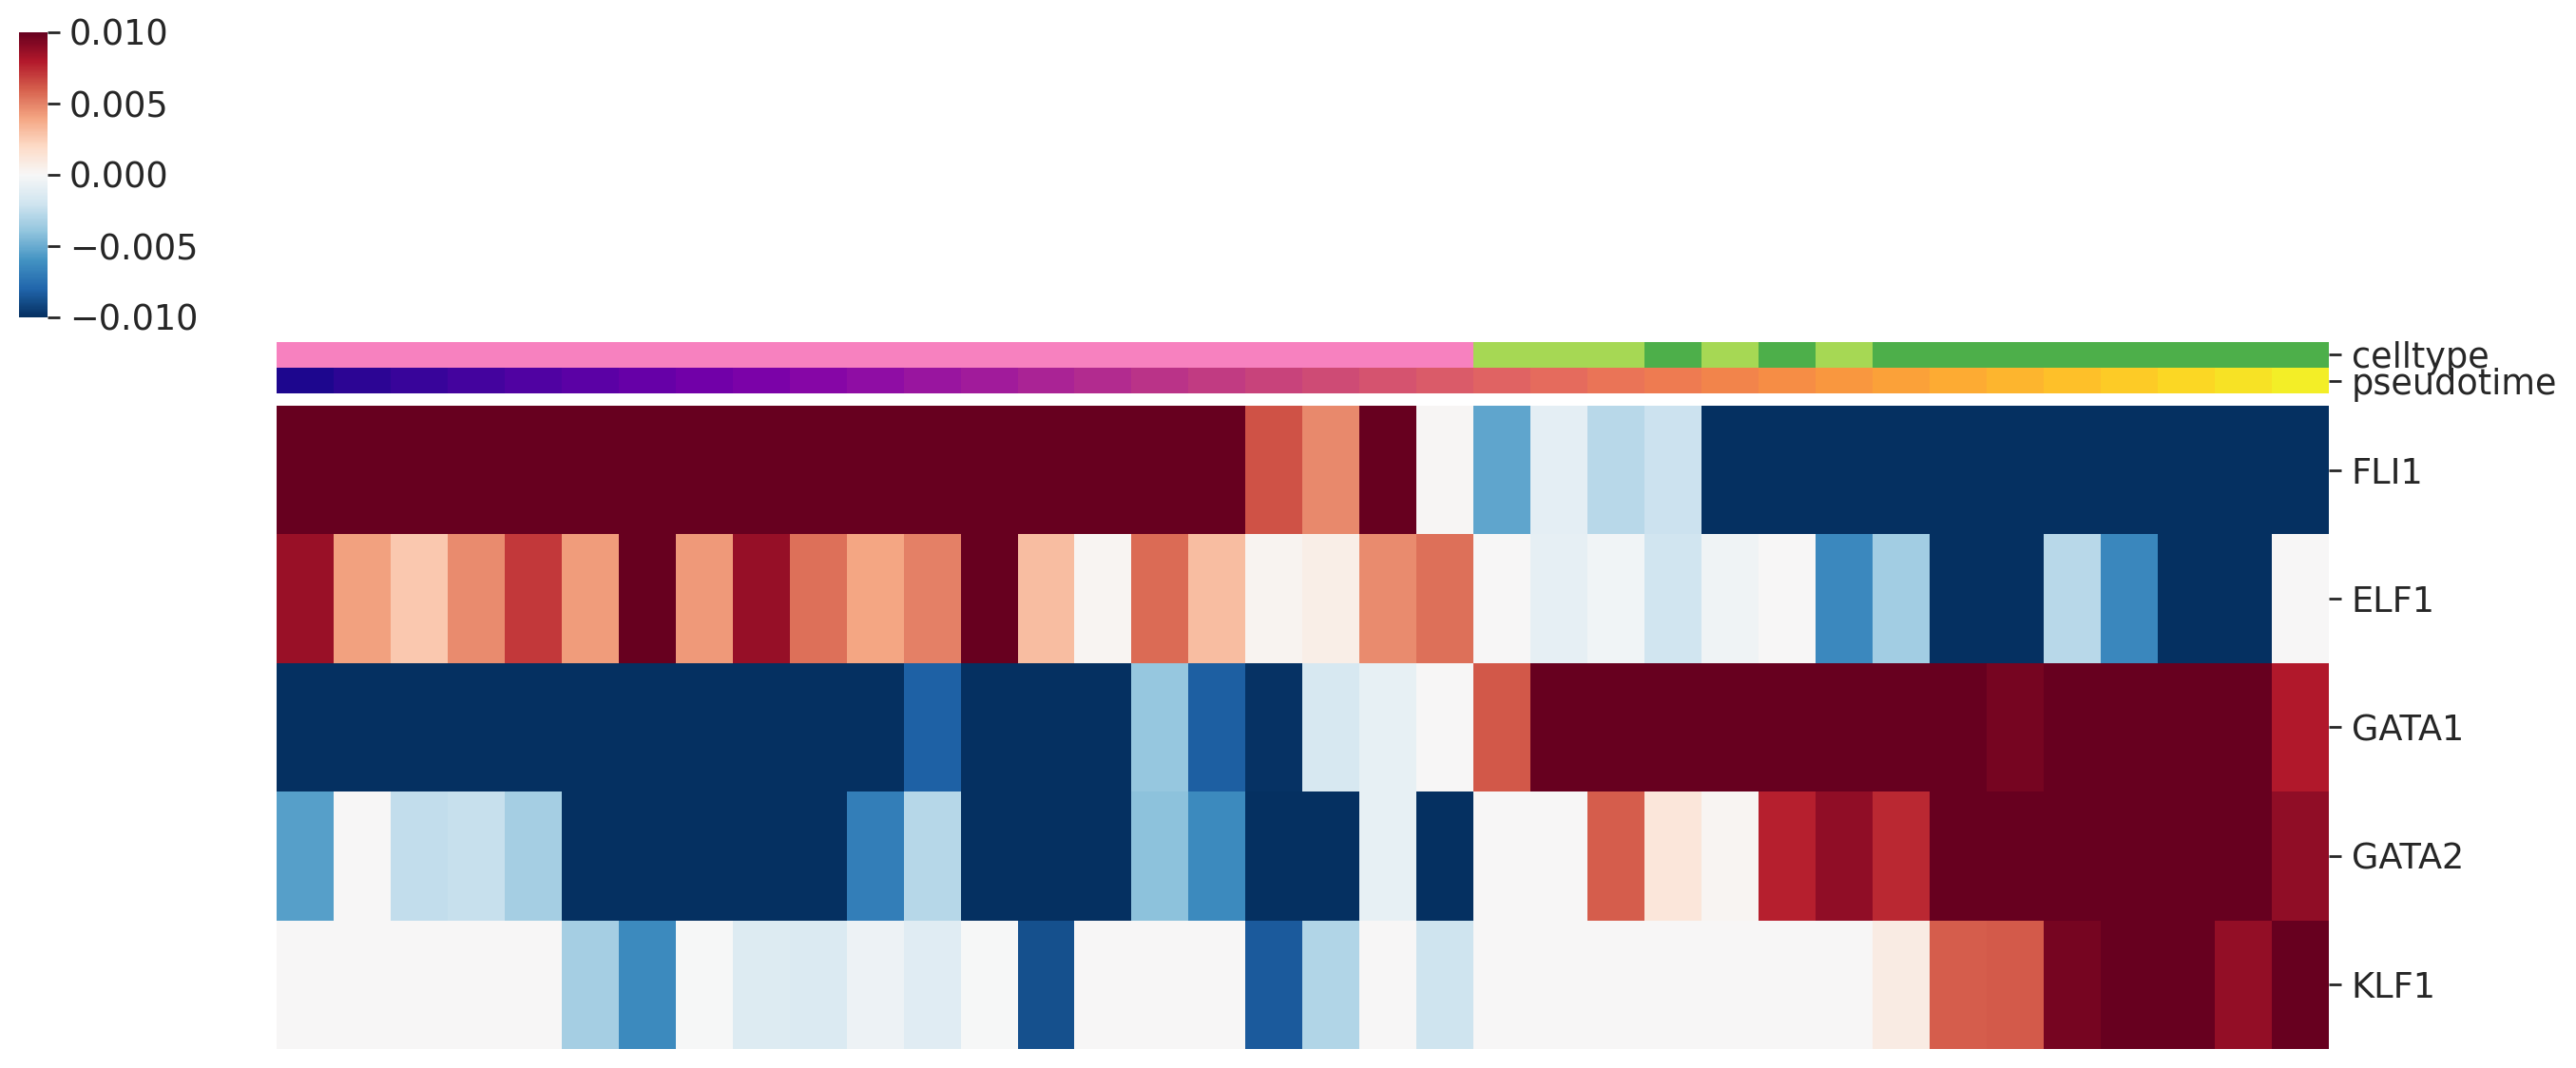

In [71]:
plot_dependencies(mc_sub, mc_activity.loc[tfs_oi], save=False,row_cluster=False, fsize=(15,5),fname='mc_tf_coefficents')

## cell type specific

In [72]:
# compute activity for top metacell tfs using lasso regression based on cell type specific gene-TF matrix
ery_activities = {}
for ct in ery_cts:
    ct_cells = mc_ad.obs_names[mc_ad.obs['celltype'] == ct]
    ery_activities[ct] = find_error_change(mc_sub, ery_traj[ct], top_ery_tfs,ct_cells,)
ery_activity = pd.concat(ery_activities.values(), axis=1)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

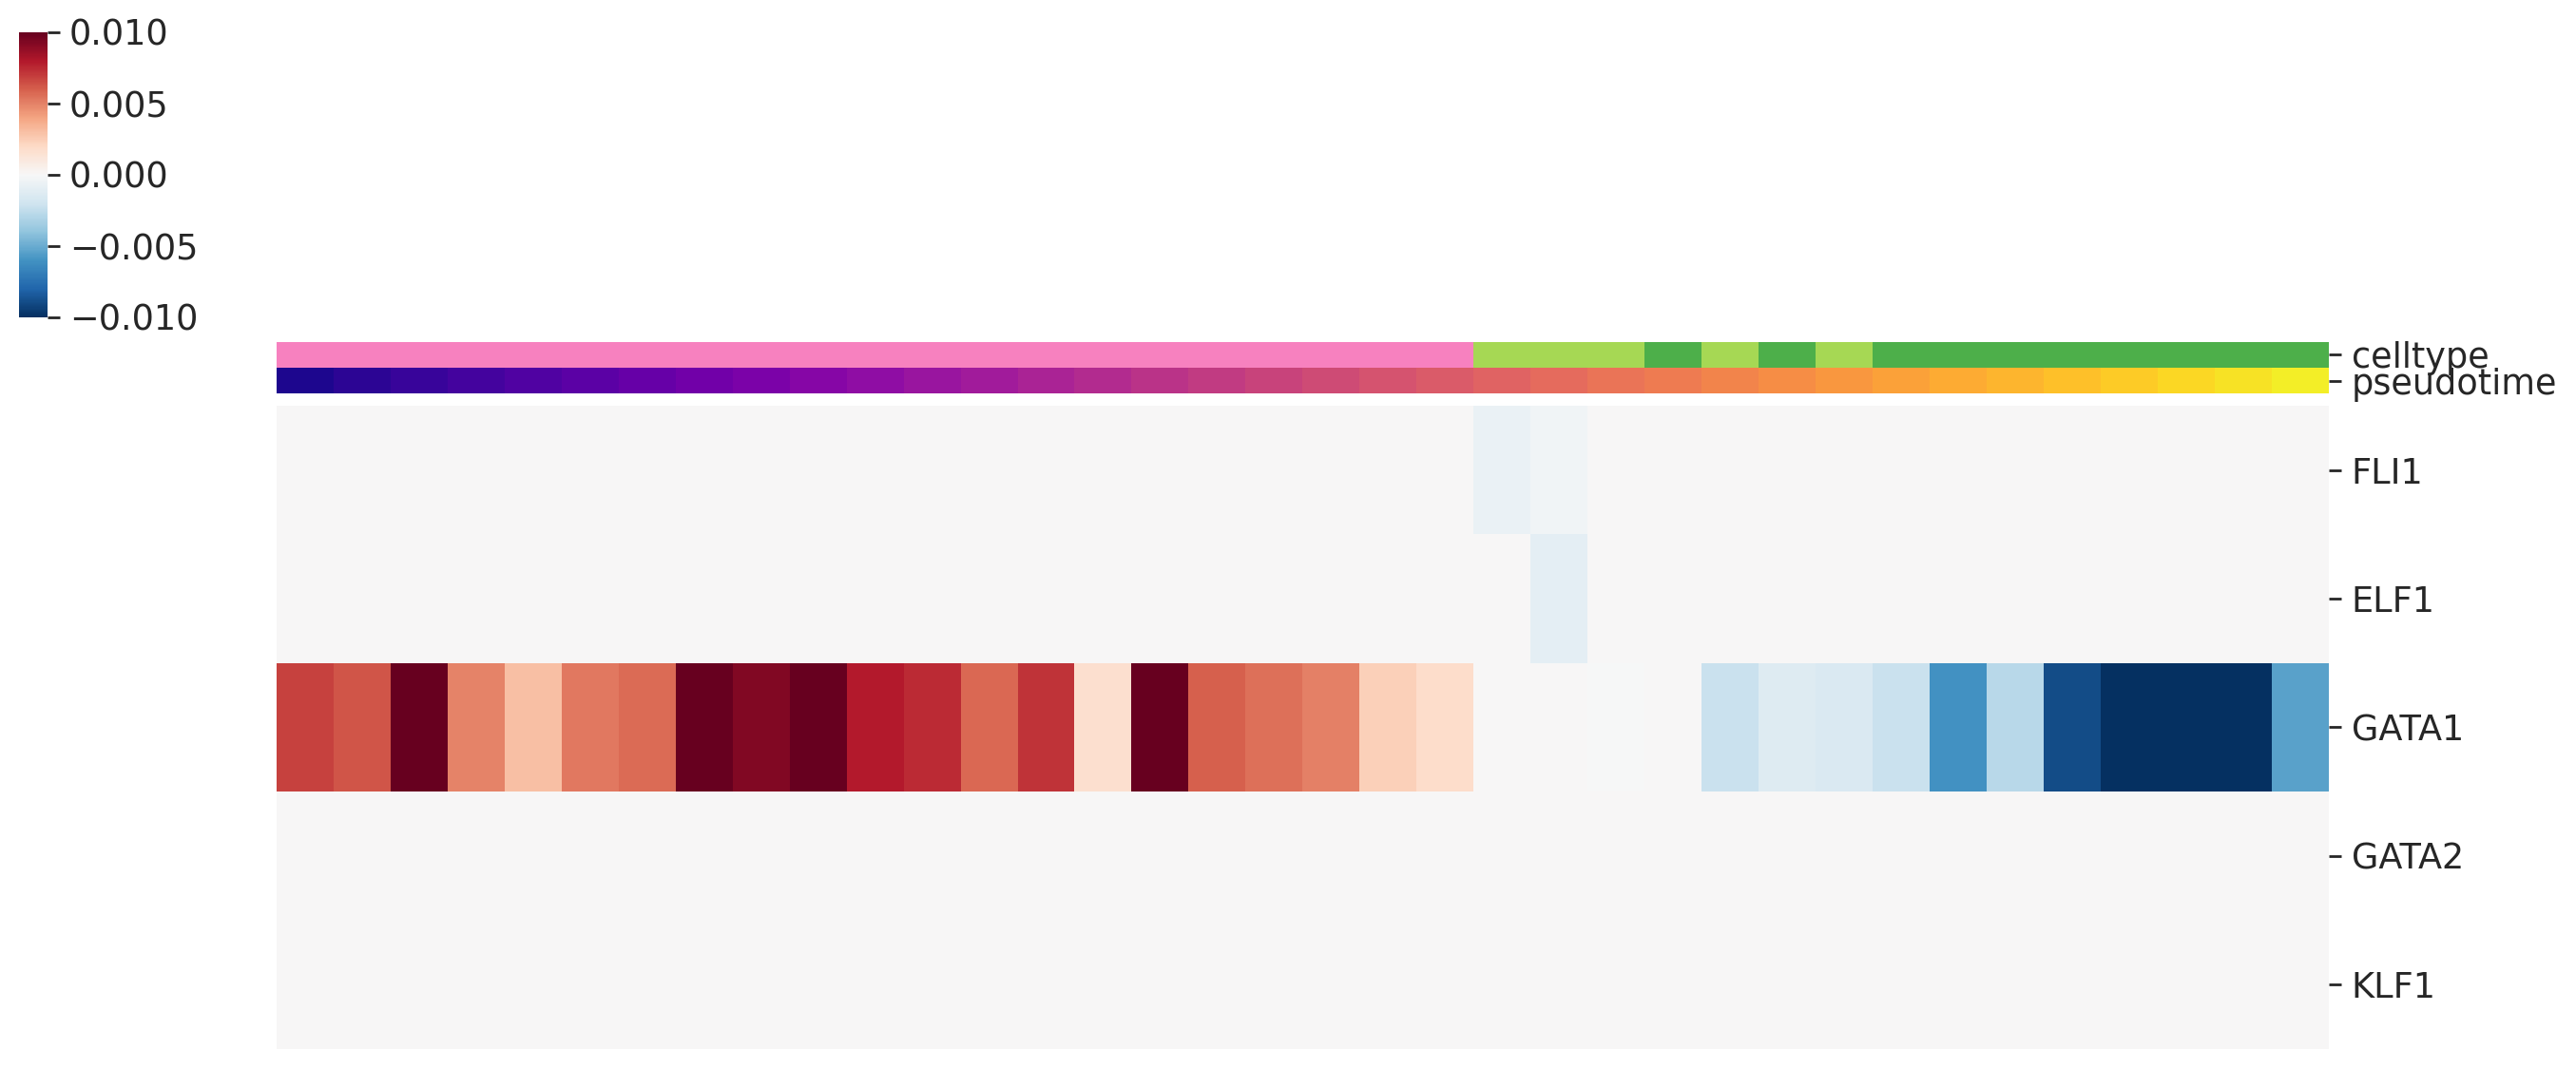

In [76]:
cell_order = mc_sub.obs.sort_values('palantir_pseudotime').index
plot_dependencies(mc_sub, ery_activity.loc[tfs_oi, cell_order], fsize=(15,5),
                  save=False, row_cluster=False, fname='ct_specific_tf_match')